## Imports

In [1]:
from astropy.stats import sigma_clipped_stats
from astropy.io import fits
from photutils.aperture import ApertureStats, CircularAperture, CircularAnnulus, aperture_photometry
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import SigmaClip
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import pandas as pd
import os
import glob
from astropy.time import Time
import warnings
warnings.filterwarnings('ignore')

## Definitions

#### This is long but it is where all the juicy parts are (photometry, error calculation, conversion to magnitude, etc)
#### User should only need to change the star list at this step to perform_phot to run properly
#### At beginning of definitions, define the star list to make sure it always falls back to it
Each time you come up with a new star list I suggest hardcoding it into the defaults so you know it will always fall back to it.

In [ ]:
star_list_pix = [(1191.8764360055145,1066.6640350183595),(802.244336955459,1306.4192201756005),(650.3837354957774,1196.9943107017784),(1524.08865425637,1380.9930076382311),(1130.4734973933912,948.7168556741947)]

aperture_radius = 12  # Radius of the aperture
annulus_inner_radius = 32  # Inner radius of the annulus
annulus_outer_radius = 40  # Outer radius of the annulus

rdnoise = 5
gain = 0.27

def perform_phot(file_dir=None, ref_image=None, filt=None,
        aperture_radius = aperture_radius,  # Radius of the aperture
        annulus_inner_radius = annulus_inner_radius,  # Inner radius of the annulus
        annulus_outer_radius = annulus_outer_radius,  # Outer radius of the annulus
        star_list = star_list_pix, # star list in pixel coords for reference imaage
        ref_star_coords = None, # star list in ra/dec coords for reference image
        save_ref_star_coords = False, # save the star list in ra/dec coords for reference image
        display_apertures = False, # display the apertures and annuli on the reference image
        target_name = None, # Target name for WCS, if none provided, it will be taken from the header
        save_file = True, # save the results to a file
        plot_file = True, # plot the results
        rdnoise = rdnoise, # in e-/pix THIS NEEDS TO BE CHECKED FOR BIN MODE this was measured for 2x2 binning
        gain = gain, # in e-/ADU
        ):
    
    # Check that the directory exists
    if file_dir is None:
        print('No directory provided. Using current working directory.')
        file_dir = os.getcwd()
    else:
        print('Using directory:', file_dir)
        # Change to the directory containing the images
        os.chdir(file_dir)
        # Check if the directory exists
        if not os.path.isdir(file_dir):
            print('Directory does not exist. Exiting.')
            return
    
    # If filt is not provided, set it to 'V'
    if filt is None:
        print('No filt provided. Using default filt: V')
        filt = 'V'
    else:
        print('Using filt:', filt)

    # Set the reference image
    if ref_image is None:
        print('No reference image provided. Using the first image in the directory.')
        types = ['*.fts', '*.fit', '*.fits']
        for type in types:
            ref_image = glob.glob(file_dir + '/' + filt + '/' + type)
            if ref_image:
                ref_image = ref_image[0]
                break
        else:
            print('No reference image found in the directory. Exiting.')
            return
    else:
        print('Using reference image:', ref_image)
        # Check if the reference image exists
        if not os.path.isfile(ref_image):
            print('Reference image not found in the directory. Exiting.')
            return

    # Find all FITS files in the directory
    types = ['*.fts', '*.fit', '*.fits']
    for type in types:
        image_files = glob.glob(file_dir + '/' + filt + '/' + type)
        if image_files:
            break
    else:
        print('No FITS files found in the directory. Exiting.')
        return

    data = fits.getdata(ref_image)
    header = fits.getheader(ref_image)

    # Get read noise and gain
    rdnoise = rdnoise # This is appropriate for the ATIK ONE
    gain = gain

    # Get the WCS information from the header    
    wcs = WCS(header)

    # Check if the target name is provided, if not, use the one from the header
    if target_name is None:
        try:
            target_name = header['BLKNAME']
        except KeyError:
            target_name = header['OBJECT']
    
    print('Target Name:', target_name)

    # Convert the target coordinates to degrees
    target = SkyCoord.from_name(target_name)
    ra = target.ra.deg
    dec = target.dec.deg
    print('Target RA:', ra)
    print('Target Dec:', dec)
    # Check if the reference star coordinates are provided
    if ref_star_coords:
        print('Using reference star coordinates')
        star_list_ra_dec = pd.read_csv(ref_star_coords).values.tolist()
    else:
    # Convert the star list from pixel coordinates to RA/Dec coordinates
        header = fits.getheader(ref_image)
        wcs = WCS(header)
        star_list_ra_dec = []
        for x, y in star_list:
            star_ra, star_dec = wcs.all_pix2world(x, y, 0)
            star_list_ra_dec = star_list_ra_dec + [(star_ra, star_dec)]
        if save_ref_star_coords:
            star_list_saving = pd.DataFrame(star_list_ra_dec, columns=['RA', 'Dec'])
            target_name = target_name.replace(' ', '_')
            star_list_saving.to_csv(file_dir + '/' + target_name + '_ref_star_coords.csv', index=False)
            print('Saving reference star coordinates to', file_dir + '/' + target_name + '_ref_star_coords.csv')            

    # Initialize a list to store results for all files
    all_results = []

    # Loop over each image file
    for image_file in image_files:
        # Load the FITS data
        data = fits.getdata(image_file)
        header = fits.getheader(image_file)
        #print('Processing', image_file)

        wcs = WCS(header)
        xst, yst = wcs.all_world2pix(ra, dec,0)
        star_list = []
        for x, y in star_list_ra_dec:
            x_star, y_star = wcs.all_world2pix(x, y,0)
            star_list = star_list + [(x_star, y_star)]
        xst = float(xst)
        yst = float(yst)
        star_list = [(xst, yst)] + star_list
        
        # Pull the exposure time from the header, convert to days 
        # Get the Julian Date from the header and add the half exposure time to get the mid-exposure time
        exptime = header['EXPTIME']
        exptimedays = exptime/(24*3600)
        addjd = exptimedays/2
        # Initialize a dictionary to store the results for this file
        ut_date = header['DATE-OBS'] 
        # Create an Astropy Time object
        t = Time(ut_date, scale='utc')
        # Get the Julian Date
        jd = t.jd
        #jd = header['JD']
        file_results = {'file': image_file, 'Julian_Date': (jd+addjd)}
        
        # Stats for sigma clipping
        sigclip = SigmaClip(sigma=3., maxiters=10)
        
        # Perform aperture photometry for each star
        for i, (x, y) in enumerate(star_list):
            ap = CircularAperture((x, y), r=aperture_radius)
            an = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
            bkg_stats = ApertureStats(data, an, sigma_clip=sigclip)
            ap_stats = ApertureStats(data, ap, local_bkg=bkg_stats.median)

            # Recentroid the aperture
            x, y = ap_stats.centroid
            
        
            aperture = CircularAperture((x, y), r=aperture_radius)
            annulus_aperture = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
            
            # Perform aperture photometry
            phot_table = aperture_photometry(data, aperture)
            bkgstats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
            
            # Calculate the background in the annulus
            bkg_mean = bkgstats.mean
            bkg_sum = bkg_mean * aperture.area
            
    

            
            # Subtract the background from the aperture photometry
            source_sum = phot_table['aperture_sum'][0]*gain - bkg_sum*gain

            # Check if the source sum is negative and skip if it is
            if source_sum < 0:
                print(f"Skipping {image_file} due to negative source sum, image should be inspected.")
                continue

            # Error calculation (Poisson noise + background noise + read noise)
            error = np.sqrt((phot_table['aperture_sum'][0]-aperture.area)*gain + ((aperture.area)/annulus_aperture.area)*bkg_sum*gain + aperture.area*rdnoise**2)

            # Optionally turn into a magnitude (not used here but useful for reference)
            source_mag = -2.5 * np.log10(source_sum / exptime)
            source_mag_err = 1.0857 * error / source_sum

            # Store the results with dynamic column names
            file_results[f'star_{i}_x'] = x
            file_results[f'star_{i}_y'] = y
            file_results[f'star_{i}_flux'] = source_sum
            file_results[f'star_{i}_error'] = error
            file_results[f'star_{i}_background'] = bkg_sum

        # Append the results for this file to the list of all results
        all_results.append(file_results)

    # Convert the results to a DataFrame for easy analysis
    results_df = pd.DataFrame(all_results)

    # Rename the columns to remove the 'star_0_' prefix for the first star
    # and replace it with 'target_' for clarity
    results_df.rename(
    columns=lambda c: c.replace("star_0_", "target_")
    if c.startswith("star_0_") else c,
    inplace=True
)

    # Optionally, display the image with the apertures and annuli (set flag to True)
    # This is useful for checking the positions of the stars are correct
    if display_apertures:
        for image_file in image_files:
            data = fits.getdata(image_file)
            header = fits.getheader(image_file)
            wcs = WCS(header)

            plt.imshow(data, vmin=np.percentile(data, 5), vmax=np.percentile(data, 99), cmap='viridis')
            for (x, y) in star_list:
                aperture = CircularAperture((x, y), r=aperture_radius)
                annulus_aperture = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
                aperture.plot(color='blue', lw=1.5)
                annulus_aperture.plot(color='red', lw=1.5)
            plt.show()

    # add all the comparison stars together
    results_df['total_flux'] = results_df['star_1_flux'] + results_df['star_2_flux'] + results_df['star_3_flux'] + results_df['star_4_flux'] + results_df['star_5_flux']
    
    # calculate the relative flux of the target star
    results_df['target_rel_flux']=results_df['target_flux']/results_df['total_flux']

    # calculate the relative flux of the comparison stars
    for i in range(1,6):
        results_df[f'star_{i}_relflux'] = results_df[f'star_{i}_flux']/results_df['total_flux']

    # calculate the error on the total flux
    total_flux_err = np.sqrt(results_df['star_1_error']**2 + results_df['star_2_error']**2 + results_df['star_3_error']**2 + results_df['star_4_error']**2 + results_df['star_5_error']**2)

    #calculate the error on the relative flux
    results_df['target_relerror'] = (results_df['target_flux']/results_df['total_flux'])*(np.sqrt((results_df['target_error']/results_df['target_flux'])**2 + (total_flux_err/results_df['total_flux'])**2))

    # Normalize the relative flux
    mean_rel_flux, _, _, = sigma_clipped_stats(results_df['target_rel_flux'], sigma=  2.0)
    results_df['norm_target_rel_flux'] = results_df['target_rel_flux']/mean_rel_flux
    results_df['norm_target_rel_flux_error'] = results_df['target_relerror']/mean_rel_flux

    # Save the results to a CSV file
    if save_file:
        results_df.to_csv(file_dir + 'Results_' + filt + '.csv', index=False)

    if plot_file:
        #Plot the relative flux
        #plt.plot(results_df['Julian_Date'], results_df['target_rel_flux'], 'o')
        plt.errorbar(results_df['Julian_Date'], results_df['target_rel_flux'], yerr=results_df['target_relerror'], fmt='o')
        plt.xlabel('Julian Date')
        plt.ylabel('Relative Flux')
        plt.show()

    # Return the results DataFrame
    return results_df

def make_light_curve(file_dir, filters=None, title=None, comp_stars=False):
    # Change to the directory containing the images
    os.chdir(file_dir)
    print('Current working directory:', os.getcwd())
    # Check if the directory exists
    if not os.path.isdir(file_dir):
        print('Directory does not exist. Exiting.')
        return
    
    # If filters are not provided, set it to ['B', 'V', 'R', 'I']
    if filters is None:
        print('No filters provided. Using default filters: B, V, R, I')
        filters = ['B', 'V', 'R', 'I']
    else:
        print('Using filters:', filters)

    try:
        lc_B = pd.read_csv(file_dir + 'Results_B.csv')
        lc_B = lc_B.sort_values(by=['Julian_Date'])
        plt.errorbar(lc_B['Julian_Date'], lc_B['norm_target_rel_flux'], yerr=lc_B['norm_target_rel_flux_error'], fmt='o', label='B', color='blue')
        plt.plot(lc_B['Julian_Date'], lc_B['norm_target_rel_flux'], color='blue')
    except FileNotFoundError:
        print('No B filter data found. Skipping B filter.')
    try:
        lc_V = pd.read_csv(file_dir + 'Results_B.csv')
        lc_V = lc_V.sort_values(by=['Julian_Date'])
        plt.errorbar(lc_V['Julian_Date'], lc_V['norm_target_rel_flux'], yerr=lc_V['norm_target_rel_flux_error'], fmt='o', label='V', color='green')
        plt.plot(lc_V['Julian_Date'], lc_V['norm_target_rel_flux'], color='green')
    except FileNotFoundError:
        print('No V filter data found. Skipping V filter.')
    try:
        lc_R = pd.read_csv(file_dir + 'Results_R.csv')
        lc_R = lc_R.sort_values(by=['Julian_Date'])
        plt.errorbar(lc_R['Julian_Date'], lc_R['norm_target_rel_flux'], yerr=lc_R['norm_target_rel_flux_error'], fmt='o', label='R', color='red')
        plt.plot(lc_R['Julian_Date'], lc_R['norm_target_rel_flux'], color='red')
    except FileNotFoundError:
        print('No R filter data found. Skipping r filter.')
    try:
        lc_I = pd.read_csv(file_dir + 'Results_I.csv')
        lc_I = lc_I.sort_values(by=['Julian_Date'])
        plt.errorbar(lc_I['Julian_Date'], lc_I['norm_target_rel_flux'], yerr=lc_I['norm_target_rel_flux_error'], fmt='o', label='I', color='purple')
        plt.plot(lc_I['Julian_Date'], lc_I['norm_target_rel_flux'], color='purple')
    except FileNotFoundError:
        print('No I filter data found. Skipping I filter.')

    # If comp_stars is True, plot the comparison stars
    if comp_stars:
        try:
            lc_B = pd.read_csv(file_dir + 'Results_B.csv')
            lc_B = lc_B.sort_values(by=['Julian_Date'])
            plt.scatter(lc_B['Julian_Date'], lc_B['star_1_relflux']/np.mean(lc_B['star_1_relflux']), alpha=0.2, color='C0')
            plt.scatter(lc_B['Julian_Date'], lc_B['star_2_relflux']/np.mean(lc_B['star_2_relflux']), alpha=0.2, color='C1')
            plt.scatter(lc_B['Julian_Date'], lc_B['star_3_relflux']/np.mean(lc_B['star_3_relflux']), alpha=0.2, color='C2')
            plt.scatter(lc_B['Julian_Date'], lc_B['star_4_relflux']/np.mean(lc_B['star_4_relflux']), alpha=0.2, color='C3')
            plt.scatter(lc_B['Julian_Date'], lc_B['star_5_relflux']/np.mean(lc_B['star_5_relflux']), alpha=0.2, color='C4')
        except FileNotFoundError:
            print('No B filter data found. Skipping B filter.')
        try:
            lc_V = pd.read_csv(file_dir + 'Results_B.csv')
            lc_V = lc_V.sort_values(by=['Julian_Date'])
            plt.scatter(lc_V['Julian_Date'], lc_V['star_1_relflux']/np.mean(lc_V['star_1_relflux']), alpha=0.2, color='C0')
            plt.scatter(lc_V['Julian_Date'], lc_V['star_2_relflux']/np.mean(lc_V['star_2_relflux']), alpha=0.2, color='C1')
            plt.scatter(lc_V['Julian_Date'], lc_V['star_3_relflux']/np.mean(lc_V['star_3_relflux']), alpha=0.2, color='C2')
            plt.scatter(lc_V['Julian_Date'], lc_V['star_4_relflux']/np.mean(lc_V['star_4_relflux']), alpha=0.2, color='C3')
            plt.scatter(lc_V['Julian_Date'], lc_V['star_5_relflux']/np.mean(lc_V['star_5_relflux']), alpha=0.2, color='C4')
        except FileNotFoundError:
            print('No V filter data found. Skipping B filter.')
        try:
            lc_R = pd.read_csv(file_dir + 'Results_R.csv')
            lc_R = lc_R.sort_values(by=['Julian_Date'])
            plt.scatter(lc_R['Julian_Date'], lc_R['star_1_relflux']/np.mean(lc_R['star_1_relflux']), alpha=0.2, color='C0')
            plt.scatter(lc_R['Julian_Date'], lc_R['star_2_relflux']/np.mean(lc_R['star_2_relflux']), alpha=0.2, color='C1')
            plt.scatter(lc_R['Julian_Date'], lc_R['star_3_relflux']/np.mean(lc_R['star_3_relflux']), alpha=0.2, color='C2')
            plt.scatter(lc_R['Julian_Date'], lc_R['star_4_relflux']/np.mean(lc_R['star_4_relflux']), alpha=0.2, color='C3')
            plt.scatter(lc_R['Julian_Date'], lc_R['star_5_relflux']/np.mean(lc_R['star_5_relflux']), alpha=0.2, color='C4')
        except FileNotFoundError:
            print('No R filter data found. Skipping r filter.')
        try:
            lc_I = pd.read_csv(file_dir + 'Results_I.csv')
            lc_I = lc_I.sort_values(by=['Julian_Date'])
            plt.scatter(lc_I['Julian_Date'], lc_I['star_1_relflux']/np.mean(lc_I['star_1_relflux']), alpha=0.2, color='C0')
            plt.scatter(lc_I['Julian_Date'], lc_I['star_2_relflux']/np.mean(lc_I['star_2_relflux']), alpha=0.2, color='C1')
            plt.scatter(lc_I['Julian_Date'], lc_I['star_3_relflux']/np.mean(lc_I['star_3_relflux']), alpha=0.2, color='C2')
            plt.scatter(lc_I['Julian_Date'], lc_I['star_4_relflux']/np.mean(lc_I['star_4_relflux']), alpha=0.2, color='C3')
            plt.scatter(lc_I['Julian_Date'], lc_I['star_5_relflux']/np.mean(lc_I['star_5_relflux']), alpha=0.2, color='C4')
        except FileNotFoundError:
            print('No I filter data found. Skipping i filter.')
 
    # Give labels to the axes and a title
    if title is None:
        plt.title('Light Curve')
    else:
        plt.title(title)
    
    ### This is where you can add in highlighting of VLA overlap:
    # # Convert the utc to JD
    # t_start = Time('2025-05-02T06:39:00', scale='utc')
    # # Get the Julian Date
    # jd_start = t_start.jd

    # t_end = Time('2025-05-02T09:39:00', scale='utc')
    # # Get the Julian Date
    # jd_end = t_end.jd

    # plt.axvline(x=jd_start, color='black', linestyle='--')
    # plt.axvline(x=jd_end, color='black', linestyle='--')
    # plt.fill_betweenx([0.5, 1.5], jd_start, jd_end, color='blue', alpha=0.2)

    plt.xlabel('Julian Date')
    plt.ylabel('Relative Flux')
    plt.legend()
    plt.show()

def find_mags(file_dir=None, ref_image=None, filt=None,
        aperture_radius = aperture_radius,  # Radius of the aperture (needs to be the same as in perform_phot)
        annulus_inner_radius = annulus_inner_radius,  # Inner radius of the annulus (needs to be the same as in perform_phot)
        annulus_outer_radius = annulus_outer_radius,  # Outer radius of the annulus (needs to be the same as in perform_phot)
        star_list = star_list_pix, # star list in pixel coords for reference imaage
        ref_star_coords = None, # star list in ra/dec coords for reference image
        save_ref_star_coords = False, # save the star list in ra/dec coords for reference image
        display_apertures = False, # display the apertures and annuli on the reference image
        target_name = None, # Target name for WCS, if none provided, it will be taken from the header
        rdnoise = rdnoise, # in e-/pix THIS NEEDS TO BE CHECKED FOR BIN MODE this was measured for 2x2 binning
        gain = gain, # in e-/ADU
        ):
# Check that the directory exists
    if file_dir is None:
        print('No directory provided. Using current working directory.')
        file_dir = os.getcwd()
    else:
        print('Using directory:', file_dir)
        # Change to the directory containing the images
        os.chdir(file_dir)
        # Check if the directory exists
        if not os.path.isdir(file_dir):
            print('Directory does not exist. Exiting.')
            return
    
    # If filt is not provided, set it to 'g'
    if filt is None:
        print('No filt provided. Using default filt: V')
        filt = 'V'
    else:
        print('Using filt:', filt)

    # Set the reference image
    if ref_image is None:
        print('No reference image provided. Using the first image in the directory.')
        types = ['*.fts', '*.fit', '*.fits']
        for type in types:
            ref_image = glob.glob(file_dir + '/' + filt + '/' + type)
            if ref_image:
                ref_image = ref_image[0]
                break
        else:
            print('No reference image found in the directory. Exiting.')
            return
    else:
        print('Using reference image:', ref_image)
        # Check if the reference image exists
        if not os.path.isfile(ref_image):
            print('Reference image not found in the directory. Exiting.')
            return

    # Find all FITS files in the directory
    types = ['*.fts', '*.fit', '*.fits']
    for type in types:
        image_files = glob.glob(file_dir + '/' + filt + '/' + type)
        if image_files:
            break
    else:
        print('No FITS files found in the directory. Exiting.')
        return

    data = fits.getdata(ref_image)
    header = fits.getheader(ref_image)

    # Get read noise and gain
    rdnoise = rdnoise
    gain = gain

    # Get the WCS information from the header    
    wcs = WCS(header)

    # Check if the target name is provided, if not, use the one from the header
    if target_name is None:
        try:
            target_name = header['BLKNAME']
        except KeyError:
            target_name = header['OBJECT']
    
    print('Target Name:', target_name)

    # Convert the target coordinates to degrees
    target = SkyCoord.from_name(target_name)
    ra = target.ra.deg
    dec = target.dec.deg

    # Check if the reference star coordinates are provided
    if ref_star_coords:
        print('Using reference star coordinates')
        star_list_ra_dec = pd.read_csv(ref_star_coords).values.tolist()
    else:
    # Convert the star list from pixel coordinates to RA/Dec coordinates
        header = fits.getheader(ref_image)
        wcs = WCS(header)
        star_list_ra_dec = []
        for x, y in star_list:
            star_ra, star_dec = wcs.all_pix2world(x, y, 0)
            star_list_ra_dec = star_list_ra_dec + [(star_ra, star_dec)]
        if save_ref_star_coords:
            star_list_saving = pd.DataFrame(star_list_ra_dec, columns=['RA', 'Dec'])
            target_name = target_name.replace(' ', '_')
            star_list_saving.to_csv(file_dir + '/' + target_name + '_ref_star_coords.csv', index=False)
            print('Saving reference star coordinates to', file_dir + '/' + target_name + '_ref_star_coords.csv')            

    # Initialize a list to store results for all files
    all_results = []

    # Loop over each image file
    for image_file in image_files:
        # Load the FITS data
        data = fits.getdata(image_file)
        header = fits.getheader(image_file)
        #print('Processing', image_file)

        wcs = WCS(header)
        xst, yst = wcs.all_world2pix(ra, dec,0)
        star_list = []
        for x, y in star_list_ra_dec:
            x_star, y_star = wcs.all_world2pix(x, y,0)
            star_list = star_list + [(x_star, y_star)]
        xst = float(xst)
        yst = float(yst)
        star_list = [(xst, yst)] + star_list
        
        # Pull the exposure time from the header, convert to days 
        # Get the Julian Date from the header and add the half exposure time to get the mid-exposure time
        exptime = header['EXPTIME']
        exptimedays = exptime/(24*3600)
        addjd = exptimedays/2
        # Initialize a dictionary to store the results for this file
        ut_date = header['DATE-OBS']
        # Create an Astropy Time object
        t = Time(ut_date, scale='utc')
        # Get the Julian Date
        jd = t.jd
        #jd = header['JD']
        file_results = {'file': image_file, 'Julian_Date': (jd+addjd)}
        
        # Stats for sigma clipping
        sigclip = SigmaClip(sigma=3., maxiters=10)
        
        # Perform aperture photometry for each star
        for i, (x, y) in enumerate(star_list):
            ap = CircularAperture((x, y), r=aperture_radius)
            an = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
            bkg_stats = ApertureStats(data, an, sigma_clip=sigclip)
            ap_stats = ApertureStats(data, ap, local_bkg=bkg_stats.median)

            # Recentroid the aperture
            x, y = ap_stats.centroid
            
        
            aperture = CircularAperture((x, y), r=aperture_radius)
            annulus_aperture = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
            
            # Perform aperture photometry
            phot_table = aperture_photometry(data, aperture)
            bkgstats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
            
            # Calculate the background in the annulus
            bkg_mean = bkgstats.mean
            bkg_sum = bkg_mean * aperture.area
 

            
            # Subtract the background from the aperture photometry
            source_sum = phot_table['aperture_sum'][0]*gain - bkg_sum*gain

            # Check if the source sum is negative and skip if it is
            if source_sum < 0:
                print(f"Skipping {image_file} due to negative source sum, image should be inspected.")
                continue

            # Error calculation (Poisson noise + background noise + read noise)
            error = np.sqrt((phot_table['aperture_sum'][0]*aperture.area)*gain + ((aperture.area)/annulus_aperture.area)*bkg_sum*gain + aperture.area*rdnoise**2)

            # Optionally turn into a magnitude 
            header = fits.getheader(image_file)
            try:
                scale = header['SCALE']
            except KeyError:
                # If the scale is not found in the header, set it to 1
                scale = 1.0
                print('Scale not found in header, using default value of 1.0')
            try:
                zpmag = header['ZPMAG']
            except KeyError:
                # If the zero point magnitude is not found in the header, set it to 0
                zpmag = 0.0
                print('Zero point magnitude not found in header, using default value of 0.0')
            try:
                zpmag_err = header['Z_ERR']
            except KeyError:
                # If the zero point magnitude error is not found in the header, set it to 0
                zpmag_err = 0.0
                print('Zero point magnitude error not found in header, using default value of 0.0')
            source_mag = -2.5 * np.log10(scale*source_sum / exptime)
            source_mag_cor = source_mag + zpmag
            source_mag_err = 1.0857 * error / source_sum
            source_mag_cor_err = np.sqrt(source_mag_err**2 + zpmag_err**2)


            # Store the results with dynamic column names
            file_results[f'star_{i}_x'] = x
            file_results[f'star_{i}_y'] = y
            file_results[f'star_{i}_flux'] = source_sum
            file_results[f'star_{i}_error'] = error
            file_results[f'star_{i}_background'] = bkg_sum
            file_results[f'star_{i}_mag'] = source_mag_cor
            file_results[f'star_{i}_mag_error'] = source_mag_cor_err

        # Append the results for this file to the list of all results
        all_results.append(file_results)

    # Convert the results to a DataFrame for easy analysis
    results_df = pd.DataFrame(all_results)

    # Rename the columns to remove the 'star_0_' prefix for the first star
    # and replace it with 'target_' for clarity
    results_df.rename(
    columns=lambda c: c.replace("star_0_", "target_")
    if c.startswith("star_0_") else c,
    inplace=True
)

    # Optionally, display the image with the apertures and annuli (set flag to True)
    # This is useful for checking the positions of the stars are correct
    if display_apertures:
        for image_file in image_files:
            data = fits.getdata(image_file)
            header = fits.getheader(image_file)
            wcs = WCS(header)

            plt.imshow(data, vmin=np.percentile(data, 5), vmax=np.percentile(data, 99), cmap='viridis')
            for (x, y) in star_list:
                aperture = CircularAperture((x, y), r=aperture_radius)
                annulus_aperture = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
                aperture.plot(color='blue', lw=1.5)
                annulus_aperture.plot(color='red', lw=1.5)
            plt.show()

    # add all the comparison stars together
    results_df['total_flux'] = results_df['star_1_flux'] + results_df['star_2_flux'] + results_df['star_3_flux'] + results_df['star_4_flux'] + results_df['star_5_flux']
    
    # calculate the relative flux of the target star
    results_df['target_rel_flux']=results_df['target_flux']/results_df['total_flux']

    # calculate the relative flux of the comparison stars
    for i in range(1,6):
        results_df[f'star_{i}_relflux'] = results_df[f'star_{i}_flux']/results_df['total_flux']

    # calculate the error on the total flux
    total_flux_err = np.sqrt(results_df['star_1_error']**2 + results_df['star_2_error']**2 + results_df['star_3_error']**2 + results_df['star_4_error']**2 + results_df['star_5_error']**2)

    #calculate the error on the relative flux
    results_df['target_relerror'] = (results_df['target_flux']/results_df['total_flux'])*(np.sqrt((results_df['target_error']/results_df['target_flux'])**2 + (total_flux_err/results_df['total_flux'])**2))

    # Normalize the relative flux
    mean_rel_flux, _, _, = sigma_clipped_stats(results_df['target_rel_flux'], sigma=  2.0)
    results_df['norm_target_rel_flux'] = results_df['target_rel_flux']/mean_rel_flux
    results_df['norm_target_rel_flux_error'] = results_df['target_relerror']/mean_rel_flux

    # Save the results to a CSV file
    results_df.to_csv(file_dir + 'Results_Cal_' + filt + '.csv', index=False)

def calc_ap_ratio(file_dir=None, ref_image=None, filt=None,
        aperture_radius = aperture_radius,  # Radius of the aperture (needs to be the same as in perform_phot)
        annulus_inner_radius = annulus_inner_radius,  # Inner radius of the annulus (needs to be the same as in perform_phot)
        annulus_outer_radius = annulus_outer_radius,  # Outer radius of the annulus (needs to be the same as in perform_phot)
        target_name = None, # Target name for WCS, if none provided, it will be taken from the header
        star_list = star_list_pix, # star list in pixel coords for reference imaage
        larger_ap = 22, # Larger aperture radius
        mean=False,
        median=False,
        ):
    # Intialize the results dataframe
    results_df = pd.DataFrame()

    results_df = perform_phot(file_dir=file_dir, ref_image=ref_image, filt=filt,
                 aperture_radius=aperture_radius,
                 annulus_inner_radius=annulus_inner_radius,
                 annulus_outer_radius=annulus_outer_radius,
                 star_list=star_list,
                 target_name=target_name,
                 save_file=False,
                 plot_file=False
                 )
    #initiate a new dataframe
    scale_df = pd.DataFrame()
    # Set all the results to new colums
    for i in range(1, 5):
        scale_df[f'star_{i}_flux_original'] = results_df[f'star_{i}_flux']
        scale_df[f'star_{i}_error_original'] = results_df[f'star_{i}_error']
    
    results_df = pd.DataFrame()

    results_df = perform_phot(file_dir=file_dir, ref_image=ref_image, filt=filt,
                 aperture_radius=larger_ap,
                 annulus_inner_radius=annulus_inner_radius,
                 annulus_outer_radius=annulus_outer_radius,
                 star_list=star_list,
                 target_name=target_name,
                 save_file=False,
                 plot_file=False
                 )
    
    for i in range(1, 5):
        scale_df[f'file'] = results_df['file']
        scale_df[f'star_{i}_flux_large'] = results_df[f'star_{i}_flux']
        scale_df[f'star_{i}_error_large'] = results_df[f'star_{i}_error']
    
    # Calculate the ratio of the fluxes
    for i in range(1, 5):
        scale_df[f'file'] = results_df['file']
        scale_df[f'star_{i}_flux_ratio'] = scale_df[f'star_{i}_flux_large']/scale_df[f'star_{i}_flux_original']
        scale_df[f'star_{i}_error_ratio'] = np.sqrt((scale_df[f'star_{i}_error_original']/scale_df[f'star_{i}_flux_original'])**2 + (scale_df[f'star_{i}_error_large']/scale_df[f'star_{i}_flux_large'])**2)
    
    ratio_columns = [f'star_{i}_flux_ratio' for i in range(1, 5)]
    # Calculate the mean and median of the ratios
    if mean:
        scale_df['mean_ratio'] = scale_df[ratio_columns].mean(axis=1)
        scale_df['mean_error'] = scale_df[ratio_columns].std(axis=1)
        for fn, scale in zip(scale_df['file'], scale_df['mean_ratio']):
            fits.setval(fn,
            ext=0,
            keyword='SCALE',
            value=scale,
            comment='Photometric scale factor')
            #print('Writing mean scale factor to header:', fn, scale)
            if scale < 1:
                print('Scale factor is less than 1, check the image:', fn)
            if scale > 1.5:
                print('Scale factor is greater than 1.5, check the image:', fn)
        for fn, scale_err in zip(scale_df['file'], scale_df['mean_error']):
            fits.setval(fn,
            ext=0,
            keyword='SC_ERR',
            value=scale_err,
            comment='Scale error (std of ratios)')
    if median:
        scale_df['median_ratio'] = scale_df[ratio_columns].median(axis=1)
        scale_df['median_error'] = scale_df[ratio_columns].std(axis=1)
        for fn, scale in zip(scale_df['file'], scale_df['median_ratio']):
            fits.setval(fn,
            ext=0,
            keyword='SCALE',
            value=scale,
            comment='Photometric scale factor')
            #print('Writing median scale factor to header:', fn, scale)
            if scale < 1:
                print('Scale factor is less than 1, check the image:', fn)
            if scale > 1.5:
                print('Scale factor is greater than 1.5, check the image:', fn)
        for fn, scale_err in zip(scale_df['file'], scale_df['median_error']):
            fits.setval(fn,
            ext=0,
            keyword='SC_ERR',
            value=scale_err,
            comment='Scale error (std of ratios)')
    else:
        scale_df['median_ratio'] = scale_df[ratio_columns].median(axis=1)
        scale_df['median_error'] = scale_df[ratio_columns].std(axis=1)
        for fn, scale in zip(scale_df['file'], scale_df['median_ratio']):
            fits.setval(fn,
            ext=0,
            keyword='SCALE',
            value=scale,
            comment='Photometric scale factor')
            #print('Writing median scale factor to header:', fn, scale)
            if scale < 1:
                print('Scale factor is less than 1, check the image:', fn)
            if scale > 1.5:
                print('Scale factor is greater than 1.5, check the image:', fn)
        for fn, scale_err in zip(scale_df['file'], scale_df['median_error']):
            fits.setval(fn,
            ext=0,
            keyword='SC_ERR',
            value=scale_err,
            comment='Scale error (std of ratios)')

def absoulte_light_curve(file_dir, filters=None, title=None):
    if title is None:
        title = 'Absolute Light Curve'
    # Change to the directory containing the images
    os.chdir(file_dir)
    print('Current working directory:', os.getcwd())
    # Check if the directory exists
    if not os.path.isdir(file_dir):
        print('Directory does not exist. Exiting.')
        return
    
    # If filters are not provided, set it to ['g', 'r', 'i']
    if filters is None:
        print('No filters provided. Using default filters: g, r, i')
        filters = ['g', 'r', 'i']
    else:
        print('Using filters:', filters)
    
    # if 'B' in the filters list
    if 'B' in filters:
        results_B = pd.read_csv(file_dir + '/Results_Cal_B.csv')
        new_results_B_df = pd.DataFrame({
        'file': results_B['file'],
        'Julian_Date': results_B['Julian_Date'],
        'target_mag_B': results_B['target_mag'],
        'target_mag_err_B': results_B['target_mag_error'],})
        results_B = new_results_B_df.sort_values('Julian_Date')
        plt.errorbar(results_B['Julian_Date'], results_B['target_mag_B'], yerr=results_B['target_mag_err_B'], fmt='o-', label='B', color="green", markersize=6)
    if 'V' in filters:
        results_V = pd.read_csv(file_dir + '/Results_Cal_V.csv')
        new_results_V_df = pd.DataFrame({
        'file': results_V['file'],
        'Julian_Date': results_V['Julian_Date'],
        'target_mag_V': results_V['target_mag'],
        'target_mag_err_V': results_V['target_mag_error'],})
        results_V = new_results_V_df.sort_values('Julian_Date')
        plt.errorbar(results_V['Julian_Date'], results_V['target_mag_V'], yerr=results_V['target_mag_err_V'], fmt='o-', label='V', color="green", markersize=6)
    # if 'R' in the filters list
    if 'R' in filters:
        results_R = pd.read_csv(file_dir + '/Results_Cal_R.csv')
        new_results_R_df = pd.DataFrame({
        'file': results_R['file'],
        'Julian_Date': results_R['Julian_Date'],
        'target_mag_R': results_R['target_mag'],
        'target_mag_err_R': results_R['target_mag_error'],})
        results_R = new_results_R_df.sort_values('Julian_Date')
        plt.errorbar(results_R['Julian_Date'], results_R['target_mag_R'], yerr=results_R['target_mag_err_R'], fmt='o-', label='R', color="red", markersize=6)
    # if 'I' in the filters list
    if 'I' in filters:
        results_I = pd.read_csv(file_dir + '/Results_Cal_I.csv')
        new_results_I_df = pd.DataFrame({
        'file': results_I['file'],
        'Julian_Date': results_I['Julian_Date'],
        'target_mag_i': results_I['target_mag'],
        'target_mag_err_i': results_I['target_mag_error'],})
        results_I = new_results_I_df.sort_values('Julian_Date')
        plt.errorbar(results_I['Julian_Date'], results_I['target_mag_i'], yerr=results_I['target_mag_err_i'], fmt='o-', label='I', color="purple", markersize=6)

    plt.xlabel('Julian Date')
    plt.ylabel('Apparent Magnitude')
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.legend()
    plt.show()


def add_radio(path = None, date = None):
    # Check if the directory exists
    if path is None:
        print('No directory provided. Using current working directory.')
        path = os.getcwd()
    else:
        print('Using directory:', path)
        # Change to the directory containing the images
        os.chdir(path)
        # Check if the directory exists
        if not os.path.isdir(path):
            print('Directory does not exist. Exiting.')
            return
    # Check if the date is provided in format year-month-day
    if date is None:
        print('No date provided. Using current date.')
        date = datetime.datetime.now().strftime("%Y-%m-%d")
    else:
        print('Using date:', date)
    # Check if the date is in the correct format
    try:
        datetime.datetime.strptime(date, "%Y-%m-%d")
    except ValueError:
        print('Date is not in the correct format. Exiting.')
        return
    # Add T to end of the date
    date = date + 'T'
    # Read the radio data
    radio_data = pd.read_csv(path + '/radio.csv')
    # Read in the first column as time and the second column as flux
    time = radio_data['time'].astype(str)
    flux = radio_data['flux'].astype(float)
    flux_err = radio_data['flux_err'].astype(float)
    time_iso = date + time  # Vectorized string concatenation
    time_iso_list = time_iso.tolist() 
    t = Time(time_iso_list, format='isot', scale='utc') # Convert all at once
    jd = t.jd
    min_flux = np.min(flux)
    max_flux = np.max(flux)
    norm_x_flux = (flux-min_flux)/(max_flux-min_flux)
    norm_x_flux_err = flux_err/(np.max(flux)-np.min(flux))

    x_results = pd.DataFrame({
    'Julian_Date': jd,
    'x_flux': flux,
    'x_flux_err': flux_err,
    'norm_x_flux': norm_x_flux,
    'norm_x_flux_err': norm_x_flux_err
    })

    return x_results





## Optionally Run Zero Point Photometry on all the Images
### This will take a long time (10 min or more depending on number of images) to run

#### If it times out you should be able to restart and all the images with ZPMAG already in the header will be skipped over

#### If you want to rewrite to images that already have ZPMAG set the flag to --rewrite

#### Other flags are explained in ZPCalc.py

All you should need to change is the file dir

In [ ]:
from IPython import get_ipython
ip = get_ipython()

import os, glob, subprocess
# Set the directory containing the image folders and the filt
file_dir = '/Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated/'
filters = glob.glob(file_dir + '/*/')
filters = [os.path.basename(f.rstrip('/\\')) for f in filters]
print('Filters:', filters)
script = '/Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated/CalcZPMag_K.py' # can simply be the name of the script if it is in the same folder as this script, setting this up for colab
orig = os.getcwd()
for filt in filters:
    target_dir = os.path.join(file_dir, filt) + '/'
    print("Processing folder:", target_dir)
    # This will do `python script.py . --rewrite` *with* cwd=target_dir
    subprocess.run(
        ["python", script, ".", "--rewriteAVG"],
        cwd=target_dir,
        check=True
    )

Filters: ['R', 'I', 'V']
/Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated/R
Found files: ['Entered Coordinates_R_1x1_300.000secs_-15.02C_00019365.fit', 'Entered Coordinates_R_1x1_300.000secs_-15.02C_00019368.fit', 'Entered Coordinates_R_1x1_300.000secs_-15.02C_00019371.fit', 'Entered Coordinates_R_1x1_300.000secs_-15.02C_00019374.fit', 'Entered Coordinates_R_1x1_300.000secs_-15.02C_00019377.fit', 'Entered Coordinates_R_1x1_300.000secs_-15.02C_00019380.fit', 'flipMountNowEasy_R_1x1_300.000secs_-15.02C_00019384.fit', 'flipMountNowEasy_R_1x1_300.000secs_-15.02C_00019387.fit', 'flipMountNowEasy_R_1x1_300.000secs_-15.02C_00019390.fit', 'flipMountNowEasy_R_1x1_300.000secs_-15.02C_00019393.fit', 'flipMountNowEasy_R_1x1_300.000secs_-15.02C_00019396.fit', 'flipMountNowEasy_R_1x1_300.000secs_-15.02C_00019399.fit', 'flipMountNowEasy_R_1x1_300.000secs_-15.02C_00019402.fit', 'flipMountNowEasy_R_1x1_300.000secs_-15.02C_00019405.fit', 'flipMountNowEasy_R_1x1_300.000secs_-

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

/Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated
/Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated/I
Found files: ['Entered Coordinates_I_1x1_300.000secs_-15.02C_00019366.fit', 'Entered Coordinates_I_1x1_300.000secs_-15.02C_00019369.fit', 'Entered Coordinates_I_1x1_300.000secs_-15.02C_00019372.fit', 'Entered Coordinates_I_1x1_300.000secs_-15.02C_00019375.fit', 'Entered Coordinates_I_1x1_300.000secs_-15.02C_00019378.fit', 'Entered Coordinates_I_1x1_300.000secs_-15.02C_00019381.fit', 'flipMountNowEasy_I_1x1_300.000secs_-15.02C_00019385.fit', 'flipMountNowEasy_I_1x1_300.000secs_-15.02C_00019388.fit', 'flipMountNowEasy_I_1x1_300.000secs_-15.02C_00019391.fit', 'flipMountNowEasy_I_1x1_300.000secs_-15.02C_00019394.fit', 'flipMountNowEasy_I_1x1_300.000secs_-15.02C_00019397.fit', 'flipMountNowEasy_I_1x1_300.000secs_-15.02C_00019400.fit', 'flipMountNowEasy_I_1x1_300.000secs_-15.02C_00019403.fit', 'flipMountNowEasy_I_1x1_300.000secs_-15.02C

## Here you perform the photometry

All you should need to change is file_dir and ref_image, then comment out anything you don't want to run

### perform_phot will get you apparent light curves

### calc_ap_ratio needs to be run to get proper magnitudes

### find_mags will get you magnitudes (will be approximate without calc_ap_ratio)



Using directory: /Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated/
Using filt: R
Using reference image: /Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated/V/Entered Coordinates_V_1x1_300.000secs_-15.02C_00019363.fit
Target Name: VV Pup
Target RA: 123.77833733311
Target Dec: -19.05493491834


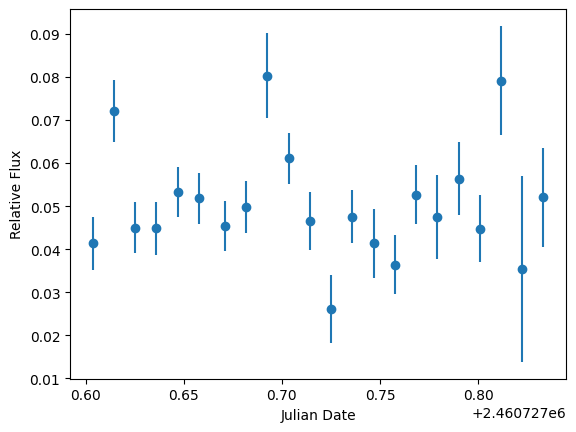

Using directory: /Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated/
Using filt: R
Using reference image: /Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated/V/Entered Coordinates_V_1x1_300.000secs_-15.02C_00019363.fit
Target Name: VV Pup
Target RA: 123.77833733311
Target Dec: -19.05493491834
Using directory: /Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated/
Using filt: R
Using reference image: /Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated/V/Entered Coordinates_V_1x1_300.000secs_-15.02C_00019363.fit
Target Name: VV Pup
Target RA: 123.77833733311
Target Dec: -19.05493491834
Using directory: /Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated/
Using filt: R
Using reference image: /Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated/V/Entered Coordinates_V_1x1_300.000secs_-15.02C_00019363.fit
Target Name: VV Pup
Saving referen

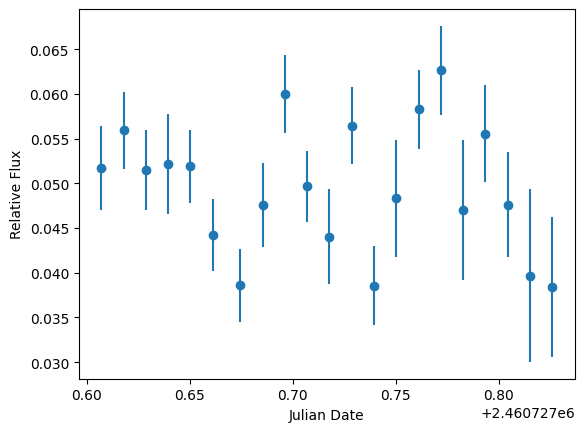

Using directory: /Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated/
Using filt: I
Using reference image: /Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated/V/Entered Coordinates_V_1x1_300.000secs_-15.02C_00019363.fit
Target Name: VV Pup
Target RA: 123.77833733311
Target Dec: -19.05493491834
Using directory: /Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated/
Using filt: I
Using reference image: /Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated/V/Entered Coordinates_V_1x1_300.000secs_-15.02C_00019363.fit
Target Name: VV Pup
Target RA: 123.77833733311
Target Dec: -19.05493491834
Using directory: /Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated/
Using filt: I
Using reference image: /Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated/V/Entered Coordinates_V_1x1_300.000secs_-15.02C_00019363.fit
Target Name: VV Pup
Saving referen

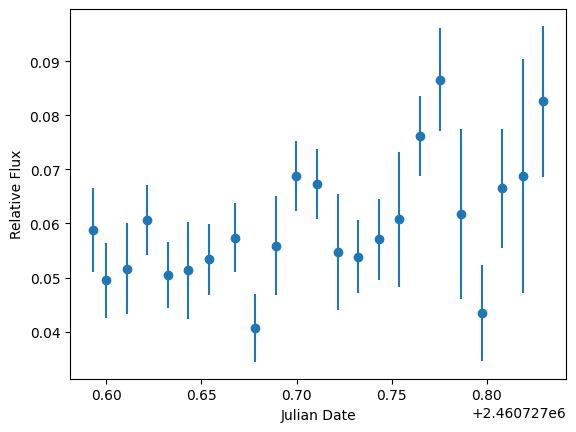

Using directory: /Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated/
Using filt: V
Using reference image: /Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated/V/Entered Coordinates_V_1x1_300.000secs_-15.02C_00019363.fit
Target Name: VV Pup
Target RA: 123.77833733311
Target Dec: -19.05493491834
Using directory: /Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated/
Using filt: V
Using reference image: /Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated/V/Entered Coordinates_V_1x1_300.000secs_-15.02C_00019363.fit
Target Name: VV Pup
Target RA: 123.77833733311
Target Dec: -19.05493491834
Scale factor is less than 1, check the image: /Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated//V/flipMountNowEasy_V_1x1_300.000secs_-15.02C_00019416.fit
Using directory: /Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated/
Using filt: V
Using referen

In [20]:
# Set the directory containing the image folders and the filt
file_dir = '/Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated/'

filters = glob.glob(file_dir + '/*/')
filters = [os.path.basename(f.rstrip('/\\')) for f in filters]

# Select the reference image (IMPORTANT: make sure this is the image that matches the coordinates of the reference stars)
ref_image = '/Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated/V/Entered Coordinates_V_1x1_300.000secs_-15.02C_00019363.fit'

# Call the function to do the photometry
for filt in filters:
    perform_phot(file_dir=file_dir, ref_image=ref_image, filt=filt, target_name='VV Pup')
    calc_ap_ratio(file_dir=file_dir, ref_image=ref_image, filt=filt, larger_ap=22, median=True, target_name='VV Pup')
    find_mags(file_dir=file_dir, ref_image=ref_image, filt=filt, save_ref_star_coords=True, target_name='VV Pup')

## Here we generate the light curves

### make_light_curve makes the relative flux normalized light curve, optionally with comparison stars

### absolute_light_curve make the magnitude based light curve

Current working directory: /Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated
Using filters: ['R', 'I', 'V']
No B filter data found. Skipping B filter.
No V filter data found. Skipping V filter.


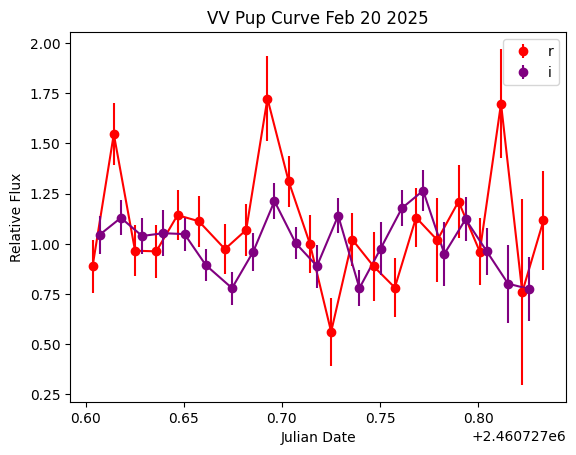

Current working directory: /Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated
Using filters: ['R', 'I', 'V']


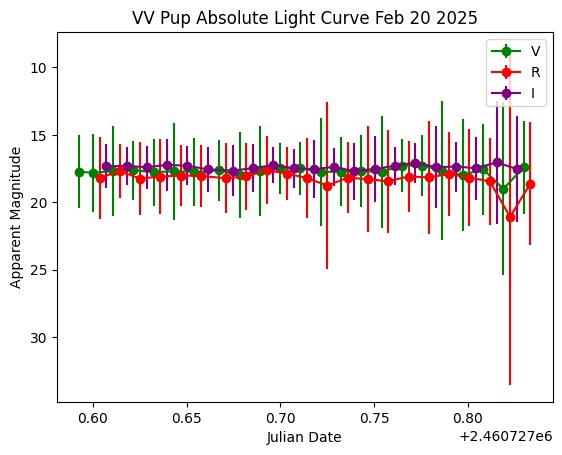

In [22]:
# Set the directory containing the image folders and the filt
file_dir = '/Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Knox_February_2025/Calibrated/'

filters = glob.glob(file_dir + '/*/')
filters = [os.path.basename(f.rstrip('/\\')) for f in filters]

make_light_curve(file_dir, filters=filters, title='VV Pup Curve Feb 20 2025', comp_stars=False)
# Call the function to make the absolute light curve
absoulte_light_curve(file_dir, filters=filters, title='VV Pup Absolute Light Curve Feb 20 2025')


## This section is for plotting the radio data up with the light curve
### Still needs to be tested

In [ ]:
#### THIS SECTION IS FOR ADDING RADIO DATA TO THE LIGHT CURVE
#### HASN'T BEEN TESTED SHOULD WORK
#### MAKES ALL PLOTS GO FROM 0 to 1 the flux scale is meaningless
# Set the directory containing the image folders and the filt
file_dir = '/Users/nathaliehaurberg/Data/MagneticCVs/MR_Ser_RLMT_May_2/'
radio_path = '/Users/nathaliehaurberg/Data/MagneticCVs/MR_Ser_RLMT_May_2/radio.csv'
title = 'MR Ser Light Curve May 3 2025 with Radio Data'

filters = glob.glob(file_dir + '/*/')
filters = [os.path.basename(f.rstrip('/\\')) for f in filters]

for filt in filters:
    results_df = perform_phot(file_dir=file_dir, ref_image=ref_image, filt=filt)
    # normalize for radio
    min_flux = np.min(results_df['target_rel_flux'])
    max_flux = np.max(results_df['target_rel_flux'])
    norm_new_flux = (results_df['target_rel_flux']-min_flux)/(max_flux-min_flux)
    norm_new_flux_err = results_df['target_relerror']/(np.max(results_df['target_rel_flux'])-np.min(results_df['target_rel_flux']))
    results_df['norm_new_flux'] = norm_new_flux
    results_df['norm_new_flux_err'] = norm_new_flux_err
    # Save the results to a CSV file
    results_df.to_csv(file_dir + 'Results_' + filt + '_radio.csv', index=False)

# Add the radio data to the light curve
radio_data = add_radio(path=radio_path, date='2025-05-03')

# Merge the radio data with the light curve data
for filt in filters:
    results_df = pd.read_csv(file_dir + 'Results_' + filt + '_radio.csv')
    results_df = results_df.merge(radio_data, on='Julian_Date', how='left')
    # Save the results to a CSV file
    results_df.to_csv(file_dir + 'Results_' + filt + '_radio.csv', index=False)
    # Plot the light curve with the radio data
    plt.errorbar(results_df['Julian_Date'], results_df['norm_new_flux'], yerr=results_df['norm_new_flux_err'], fmt='o-', label=filt, color="blue", markersize=6)
    plt.errorbar(results_df['Julian_Date'], results_df['norm_x_flux'], yerr=results_df['norm_x_flux_err'], fmt='o-', label='radio', color="red", markersize=6)
    plt.xlabel('Julian Date')
    plt.ylabel('Normalized Flux')
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.legend()
    plt.show()

